In [3]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

In [4]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [5]:
def mediapipe_detection(image,model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
    return image, results

In [6]:
def draw_landmarks(image,results):
    mp_drawing.draw_landmarks(image,results.face_landmarks,mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(0,0,255), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(255,255,255), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(0,0,255), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(255,255,255), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(0,0,255), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(255,255,255), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(0,0,255), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(255,255,255), thickness=2, circle_radius=2)
                             ) 

In [8]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as holistic:
    cv2.namedWindow("opencv feed", cv2.WND_PROP_FULLSCREEN)
    cv2.setWindowProperty("opencv feed", cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)
    
    while cap.isOpened():
        ret,frame= cap.read()
        image,results = mediapipe_detection(frame,holistic)
        print(results)
        draw_landmarks(image,results)
        cv2.imshow("opencv feed",frame)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

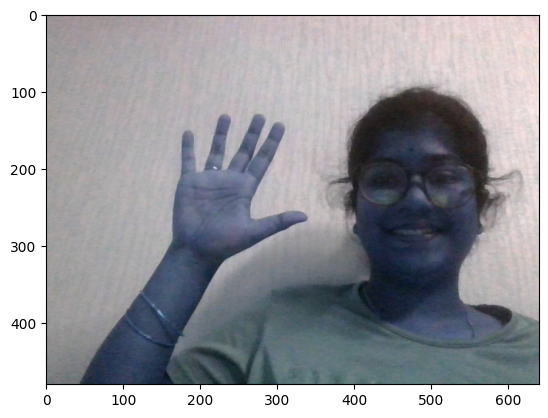

In [9]:
plt.imshow(frame)

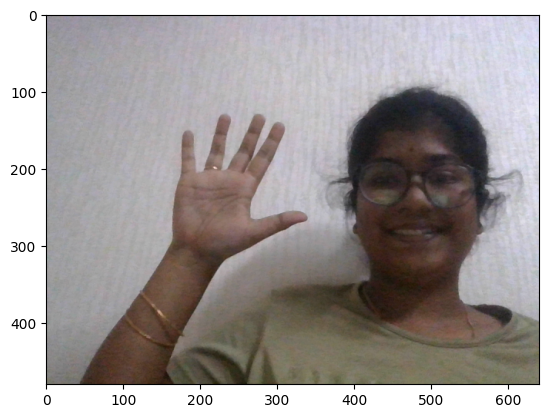

In [10]:
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

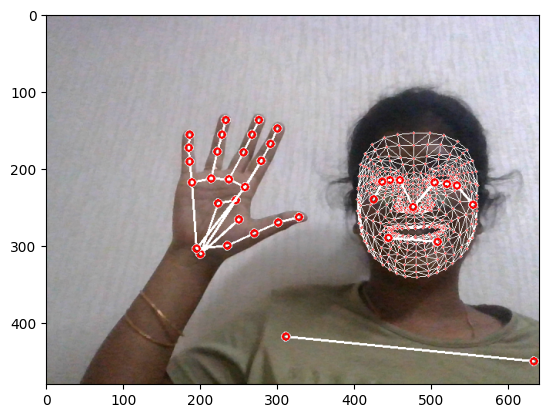

In [11]:
draw_landmarks(frame,results)
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

In [12]:
def extract_keypoints(results):
    aks=np.array([[res.x,res.y,res.z,res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*3)
    fks=np.array([[res.x,res.y,res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lks=np.array([[res.x,res.y,res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rks=np.array([[res.x,res.y,res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([aks,fks,lks,rks])

In [13]:
extract_keypoints(results).shape

(1662,)

In [14]:
result_test=extract_keypoints(results)
np.save('0',result_test)

In [15]:
np.load('0.npy')

array([ 0.74517202,  0.52228576, -1.06753063, ...,  0.29106855,
        0.32642981, -0.04317545])

In [ ]:
source_dir = 'data' 
destination_dir = 'videos_plotted'  
for action_folder in os.listdir(source_dir):
    action_folder_path = os.path.join(source_dir, action_folder)
    if os.path.isdir(action_folder_path):
        destination_action_folder = os.path.join(destination_dir, action_folder)
        os.makedirs(destination_action_folder, exist_ok=True)
        for video_name in os.listdir(action_folder_path):
            video_path = os.path.join(action_folder_path, video_name)
            if video_name.endswith('.mp4'):  # Assuming videos have .mp4 extension
                cap = cv2.VideoCapture(video_path)
                fps = cap.get(cv2.CAP_PROP_FPS)
                width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
                height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
                destination_video_path = os.path.join(destination_action_folder, video_name)
                out = cv2.VideoWriter(destination_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))
                with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
                    while cap.isOpened():
                        ret, frame = cap.read()
                        if not ret:
                            break

                        results = holistic.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                        draw_landmarks(frame, results)

                        # Save the frame to the output video
                        out.write(frame)
                        frame_count += 1
                        print(f"Processed frame {frame_count} of {video_name}")



                cap.release()
                out.release()

print("Plotted videos have been saved.")


Processed frame 79 of boy_1.mp4
Processed frame 80 of boy_1.mp4
Processed frame 81 of boy_1.mp4
Processed frame 82 of boy_1.mp4
Processed frame 83 of boy_1.mp4
Processed frame 84 of boy_1.mp4
Processed frame 85 of boy_1.mp4
Processed frame 86 of boy_1.mp4
Processed frame 87 of boy_1.mp4
Processed frame 88 of boy_1.mp4
Processed frame 89 of boy_1.mp4
Processed frame 90 of boy_1.mp4
Processed frame 91 of boy_1.mp4
Processed frame 92 of boy_1.mp4
Processed frame 93 of boy_1.mp4
Processed frame 94 of boy_1.mp4
Processed frame 95 of boy_1.mp4
Processed frame 96 of boy_1.mp4
Processed frame 97 of boy_1.mp4
Processed frame 98 of boy_1.mp4
Processed frame 99 of boy_1.mp4
Processed frame 100 of boy_1.mp4
Processed frame 101 of boy_1.mp4
Processed frame 102 of boy_1.mp4
Processed frame 103 of boy_1.mp4
Processed frame 104 of boy_1.mp4
Processed frame 105 of boy_1.mp4
Processed frame 106 of boy_1.mp4
Processed frame 107 of boy_1.mp4
Processed frame 108 of boy_1.mp4
Processed frame 109 of boy_1.mp

In [16]:
source_dir = 'data'
destination_dir = 'Processed_Frames'
for action in os.listdir(source_dir):
    action_folder = os.path.join(source_dir, action)
    if os.path.isdir(action_folder):
        destination_action_folder = os.path.join(destination_dir, action)
a        for video_file in os.listdir(action_folder):
            if video_file.endswith('.mp4'):  
                video_path = os.path.join(action_folder, video_file)
                video_name = os.path.splitext(video_file)[0]
                destination_video_folder = os.path.join(destination_action_folder, video_name)
                os.makedirs(destination_video_folder, exist_ok=True)
                cap = cv2.VideoCapture(video_path)
                frame_count = 0   
                while True:
                    ret, frame = cap.read()
                    if not ret:
                        break
                    frame_filename = os.path.join(destination_video_folder, f"frame_{frame_count:04d}.jpg")
                    cv2.imwrite(frame_filename, frame)
                    frame_count += 1
                cap.release()
print("Frames have been extracted and saved.")

KeyboardInterrupt: 

In [23]:
source_dir = 'Processed_Frames'
destination_dir = 'frames_plotted'
for action in os.listdir(source_dir):
    action_folder = os.path.join(source_dir, action)
    if os.path.isdir(action_folder):
        destination_action_folder = os.path.join(destination_dir, action)
        os.makedirs(destination_action_folder, exist_ok=True)
        for video_name in os.listdir(action_folder):
            video_folder = os.path.join(action_folder, video_name)
            if os.path.isdir(video_folder):
                destination_video_folder = os.path.join(destination_action_folder, video_name)
                os.makedirs(destination_video_folder, exist_ok=True)

                for frame_file in os.listdir(video_folder):
                    if frame_file.endswith('.jpg'):
                        frame_path = os.path.join(video_folder, frame_file)
                        frame = cv2.imread(frame_path)
                        with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
                            results = holistic.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                            draw_landmarks(frame, results)
                        plotted_frame_path = os.path.join(destination_video_folder, frame_file)
                        cv2.imwrite(plotted_frame_path, frame)
                        print(f"Plotted frame saved: {plotted_frame_path}")
print("Plotted frames have been saved.")

Plotted frame saved: frames_plotted\boy\boy_1\frame_0000.jpg
Plotted frame saved: frames_plotted\boy\boy_1\frame_0001.jpg
Plotted frame saved: frames_plotted\boy\boy_1\frame_0002.jpg
Plotted frame saved: frames_plotted\boy\boy_1\frame_0003.jpg
Plotted frame saved: frames_plotted\boy\boy_1\frame_0004.jpg
Plotted frame saved: frames_plotted\boy\boy_1\frame_0005.jpg
Plotted frame saved: frames_plotted\boy\boy_1\frame_0006.jpg
Plotted frame saved: frames_plotted\boy\boy_1\frame_0007.jpg
Plotted frame saved: frames_plotted\boy\boy_1\frame_0008.jpg
Plotted frame saved: frames_plotted\boy\boy_1\frame_0009.jpg
Plotted frame saved: frames_plotted\boy\boy_1\frame_0010.jpg
Plotted frame saved: frames_plotted\boy\boy_1\frame_0011.jpg
Plotted frame saved: frames_plotted\boy\boy_1\frame_0012.jpg
Plotted frame saved: frames_plotted\boy\boy_1\frame_0013.jpg
Plotted frame saved: frames_plotted\boy\boy_1\frame_0014.jpg
Plotted frame saved: frames_plotted\boy\boy_1\frame_0015.jpg
Plotted frame saved: fra

In [26]:
def load_data(data_path):
    sequences, labels = [], []
    actions = os.listdir(data_path)
    max_sequence_length = 0  
    for action in actions:
        action_path = os.path.join(data_path, action)
        if os.path.isdir(action_path):
            subfolders = os.listdir(action_path)
            for subfolder in subfolders:
                subfolder_path = os.path.join(action_path, subfolder)
                if os.path.isdir(subfolder_path):
                    window = []
                    for frame_num in range(500):
                        try:
                            res = np.load(os.path.join(subfolder_path, "{}.npy".format(frame_num)))
                        except FileNotFoundError:
                            # Handle the case where the file does not exist
                            res = np.zeros((num_keypoints,))  # Assuming num_keypoints is known
                        window.append(res)
                    sequences.append(window)
                    labels.append(action)
                    max_sequence_length = max(max_sequence_length, len(window))
    return np.array(sequences), np.array(labels), max_sequence_length

In [27]:
DATA_PATH = 'frames_plotted'
actions = os.listdir(DATA_PATH)
num_classes = len(actions)
sequences, labels, max_sequence_length = load_data(DATA_PATH)
x_train, x_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=42, stratify=labels)
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

NameError: name 'num_keypoints' is not defined

In [ ]:
model = Sequential()
model.add(LSTM(64, input_shape=(max_sequence_length, X_train.shape[2])))
model.add(Dense(num_classes, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=2000, batch_size=200, validation_data=(X_test, y_test))

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

In [ ]:
model.save('gesture_model.h5')

In [11]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'hello': 0, 'yes': 1, 'no': 2}

In [21]:
x= np.array(sequences)

In [22]:
y = to_categorical(labels).astype(int)

In [23]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.5)

In [24]:
y_train.shape

(45, 3)

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense
from tensorflow.keras.callbacks import TensorBoard

In [30]:
log_dir = os.path.join('Log')
tb_callback = TensorBoard(log_dir=log_dir)

In [14]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [16]:
res = [.7, 0.2, 0.1]


In [17]:
actions[np.argmax(res)]


'hello'

In [18]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])


In [46]:
model.fit(x_train, y_train, epochs=2000, callbacks=[tb_callback])


Epoch 1/2000
2/2 [==============================] - 9s 119ms/step - loss: 1.0975 - categorical_accuracy: 0.3333
Epoch 2/2000
2/2 [==============================] - 0s 121ms/step - loss: 1.1398 - categorical_accuracy: 0.3333
Epoch 3/2000
2/2 [==============================] - 0s 106ms/step - loss: 1.1446 - categorical_accuracy: 0.3778
Epoch 4/2000
2/2 [==============================] - 0s 112ms/step - loss: 1.0981 - categorical_accuracy: 0.3333
Epoch 5/2000
2/2 [==============================] - 0s 108ms/step - loss: 1.1131 - categorical_accuracy: 0.3778
Epoch 6/2000
2/2 [==============================] - 0s 101ms/step - loss: 5.5153 - categorical_accuracy: 0.3778
Epoch 7/2000
2/2 [==============================] - 0s 131ms/step - loss: 1.1195 - categorical_accuracy: 0.3333
Epoch 8/2000
2/2 [==============================] - 1s 406ms/step - loss: 1.1055 - categorical_accuracy: 0.3333
Epoch 9/2000
2/2 [==============================] - 0s 126ms/step - loss: 1.0996 - categorical_accuracy:

In [89]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 30, 64)            442112    
                                                                 
 lstm_16 (LSTM)              (None, 30, 128)           98816     
                                                                 
 lstm_17 (LSTM)              (None, 64)                49408     
                                                                 
 dense_15 (Dense)            (None, 64)                4160      
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                                 
 dense_17 (Dense)            (None, 3)                 99        
                                                                 
Total params: 596675 (2.28 MB)
Trainable params: 59667

In [25]:
res =model.predict(x_test)

2/2 [==============================] - 1s 15ms/step


In [26]:
actions[np.argmax((res[4]))]

'hello'

In [27]:
actions[np.argmax(y_test[4])]


'no'

In [28]:
model.save('action.h5')

D:\apps\python\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [29]:
model.load_weights('action.h5')

In [30]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
yhat = model.predict(x_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()
multilabel_confusion_matrix(ytrue, yhat)

2/2 [==============================] - 0s 13ms/step


array([[[ 0, 27],
        [ 0, 18]],

       [[29,  0],
        [16,  0]],

       [[34,  0],
        [11,  0]]], dtype=int64)

In [102]:
accuracy_score(ytrue, yhat)


0.37777777777777777

In [77]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):


        cv2.rectangle(output_frame, (0,60+num*40), np.pad(list(map(int, prob*100)), (2, 0)), colors[num], -1)

        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

TypeError: only size-1 arrays can be converted to Python scalars

<Figure size 1800x1800 with 0 Axes>